# Module 8 Final Project - Chatham

In [ ]:
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import xarray as xr
from sklearn.preprocessing import StandardScaler
import pandas as pd
from eofs.xarray import Eof

Create a dataset that contains the monthly means of Sea Surface Temperature anomalies from Jan 2003-Dec 2020 over the intended region (60°N to 60°S, 0-360) masked out over land. The data and land sea mask is available here: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download

In [2]:
# dataset = "reanalysis-era5-single-levels-monthly-means"
# request = {
#     "product_type": ["monthly_averaged_reanalysis"],
#     "year": [
#         "2003", "2004", "2005",
#         "2006", "2007", "2008",
#         "2009", "2010", "2011",
#         "2012", "2013", "2014",
#         "2015", "2016", "2017",
#         "2018", "2019", "2020"
#     ],
#     "month": [
#         "01", "02", "03",
#         "04", "05", "06",
#         "07", "08", "09",
#         "10", "11", "12"
#     ],
#     "time": ["00:00"],
#     "data_format": "netcdf",
#     "download_format": "unarchived",
#     "variable": [
#         "land_sea_mask",
#         "sea_surface_temperature"
#     ],
#     "area": [60, 0, -60, 360]
# }

# client = cdsapi.Client()
# client.retrieve(dataset, request).download()

In [2]:
ds = xr.open_dataset("50b873d6b66cc2dd5d5965c97b881736.nc")
ds

<xarray.Dataset> Size: 1GB
Dimensions:     (valid_time: 216, latitude: 481, longitude: 1440)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2003-01-01 ... 2020-12-01
  * latitude    (latitude) float64 4kB 60.0 59.75 59.5 ... -59.5 -59.75 -60.0
  * longitude   (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    number      int64 8B ...
    expver      (valid_time) <U4 3kB ...
Data variables:
    lsm         (valid_time, latitude, longitude) float32 598MB ...
    sst         (valid_time, latitude, longitude) float32 598MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-03T19:13 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
# Apply mask: keep ocean only (0 aka where lsm < 0.5)
# Extract static mask (remove time)
mask_static = ds["lsm"].isel(valid_time=0)

# Interpolate mask to SST grid (even if it looks identical)
mask_interp = mask_static.interp_like(ds["sst"])

# Apply ocean mask and verify
ds_ocean = ds.where(mask_interp < 0.5)
print("Valid ocean SST points:", int(np.isfinite(ds_ocean["sst"]).sum()))

Valid ocean SST points: 109556496


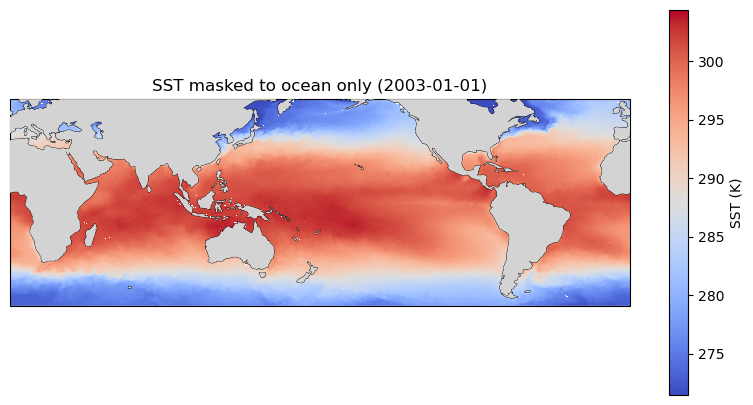

In [4]:
# testing data to see if it makes sense visually
var = "sst" 
da = ds_ocean[var].isel(valid_time=0)  # first month

plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
p = ax.pcolormesh(da.longitude, da.latitude, da, cmap="coolwarm", transform=ccrs.PlateCarree())

# add coastlines & land for reference
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.add_feature(cfeature.LAND, facecolor="lightgray", zorder=100)

# focus on extent of data
ax.set_extent([0, 360, -60, 60], crs=ccrs.PlateCarree())

# colorbar and title
plt.colorbar(p, label=f"{var.upper()} ({da.attrs.get('units','')})")
plt.title(f"{var.upper()} masked to ocean only ({str(da.valid_time.values)[:10]})")
plt.show()

Compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data. Then, standardize the SST anomalies. Standardization means subtract the long term mean and divide by the standard deviation.

In [5]:
# From Professor

def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

In [8]:
# dataset2 = "cams-global-ghg-reanalysis-egg4-monthly"
# request2 = {
#     "variable": ["co2_column_mean_molar_fraction"],
#     "year": [
#         "2003", "2004", "2005",
#         "2006", "2007", "2008",
#         "2009", "2010", "2011",
#         "2012", "2013", "2014",
#         "2015", "2016", "2017",
#         "2018", "2019", "2020"
#     ],
#     "month": [
#         "01", "02", "03",
#         "04", "05", "06",
#         "07", "08", "09",
#         "10", "11", "12"
#     ],
#     "product_type": ["monthly_mean"],
#     "data_format": "netcdf_zip",
#     "area": [60, 0, -60, 360]
# }

# client2 = cdsapi.Client()
# client2.retrieve(dataset2, request2).download()

# import zipfile
# import os

# zip_path = "790fd11f889b96fe88afddd2cc776696.zip"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall()

In [6]:
ds_co2 = xr.open_dataset("data_allhours_sfc.nc")
ds_co2

<xarray.Dataset> Size: 67MB
Dimensions:     (valid_time: 216, latitude: 161, longitude: 480)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2kB 2003-01-01 ... 2020-12-01
  * latitude    (latitude) float64 1kB 60.0 59.25 58.5 ... -58.5 -59.25 -60.0
  * longitude   (longitude) float64 4kB 0.0 0.75 1.5 2.25 ... 357.8 358.5 359.2
Data variables:
    tcco2       (valid_time, latitude, longitude) float32 67MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-04T19:22 GRIB to CDM+CF via cfgrib-0.9.1...

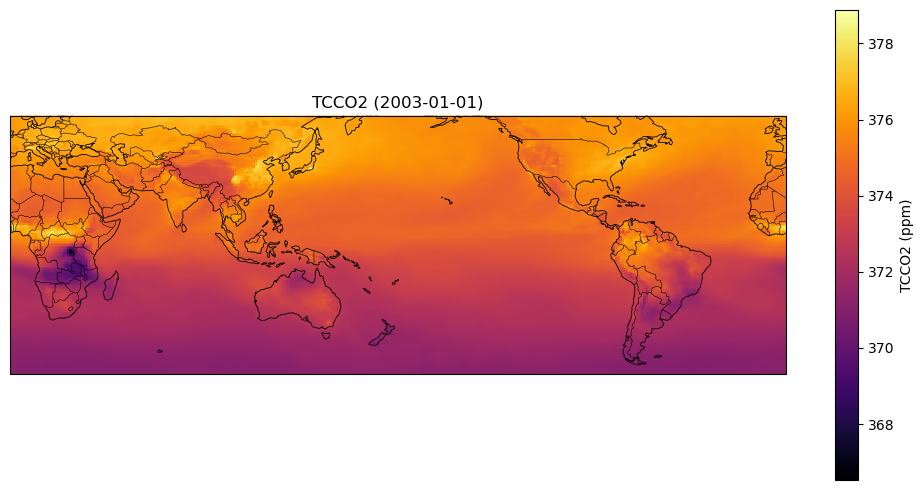

In [7]:
var = "tcco2" # CO2 column-mean molar fraction
da = ds_co2[var].isel(valid_time=0)  # first month (2003-01-01)

plt.figure(figsize=(10, 5))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# pcolormesh over lon/lat
p = ax.pcolormesh(da.longitude, da.latitude, da, cmap="inferno", transform=ccrs.PlateCarree())

# coastlines / land for reference
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)

ax.set_extent([0, 360, -60, 60], crs=ccrs.PlateCarree())

units = da.attrs.get("units", "")
plt.colorbar(p, label=f"{var.upper()} ({units})")

time_str = str(da.valid_time.values)[:10]
plt.title(f"{var.upper()} ({time_str})")

plt.tight_layout()
plt.show()

To relate CO2 variability to SST variability / ENSO, I need to deseasonalize fields (remove the strong annual cycle), detrend fields (remove long-term rising CO2 trend, and any slow SST trend), and observe anomalies that are comparable in time.

If I were to only do this for SST but leave CO2 as raw, trending values, then any correlation / EOF I would compute would be dominated by the long-term CO2 increase, not ENSO-like variability. To study shared interannual variability, I want SST anomalies and CO2 anomalies treated in a consistent way.

In [8]:
# Merge SST and CO2 onto the same time grid
combined = xr.merge([ds_ocean[["sst"]], ds_co2[["tcco2"]]])
combined = combined.chunk({"valid_time": -1})

/tmp/ipykernel_1174/2839333856.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'latitude' ('latitude',) The recommendation is to set join explicitly for this case.
  combined = xr.merge([ds_ocean[["sst"]], ds_co2[["tcco2"]]])
/tmp/ipykernel_1174/2839333856.py:2: FutureWarning: In a future version of xarray the default value for join will change from join='outer' to join='exact'. This change will result in the following ValueError: cannot be aligned with join='exact' because index/labels/sizes are not equal along these coordinates (dimensions): 'longitude' ('longitude',) The recommendation is to set join explicitly for this case.
  combined = xr.merge([ds_ocean[["sst"]], ds_co2[["tcco2"]]])


In [9]:
# Detrend all three variables at once
detr = linear_detrend(combined, time_dim="valid_time")

# Deseasonalize and compute anomalies / standardized anomalies
anom, z = monthly_anom_and_z(detr, time_dim="valid_time", base_period=None) # monthly standardized anomalies by month (z-scores per calendar month)

print("Variables in anomaly set:", list(anom.data_vars))
print("Variables in z-score set:", list(z.data_vars))

Variables in anomaly set: ['sst', 'tcco2']
Variables in z-score set: ['sst', 'tcco2']


In [10]:
# in comparison, standardizes across the full time dimension, not month-by-month
# Standardize SST anomalies
sst_anom = anom["sst"]
sst_standardized = (sst_anom - sst_anom.mean(dim="valid_time")) / sst_anom.std(dim="valid_time")
sst_standardized.name = "sst_standardized"

# Standardize CO₂ anomalies
co2_anom = anom["tcco2"] 
co2_standardized = (co2_anom - co2_anom.mean(dim="valid_time")) / co2_anom.std(dim="valid_time")
co2_standardized.name = "co2_standardized"

std_ds = xr.Dataset(
    {
        "sst_standardized": sst_standardized,
        "co2_standardized": co2_standardized,
    }
)

In [11]:
# Load into memory for validation 
sst_standardized_local = sst_standardized.compute()
co2_standardized_local = co2_standardized.compute()

# Check SST
print("SST has valid data:", np.isfinite(sst_standardized_local).any().item())
print("SST mean ~ 0:", float(sst_standardized_local.mean("valid_time", skipna=True).mean()))
print("SST std ~ 1:",  float(sst_standardized_local.std("valid_time",  skipna=True).mean()))

# Check CO2
print("CO2 has valid data:", np.isfinite(co2_standardized_local).any().item())
print("CO2 mean ~ 0:", float(co2_standardized_local.mean("valid_time", skipna=True).mean()))
print("CO2 std ~ 1:",  float(co2_standardized_local.std("valid_time",  skipna=True).mean()))

/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


SST has valid data: True
SST mean ~ 0: -5.0147944824496804e-11


/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


SST std ~ 1: 1.0
CO2 has valid data: True
CO2 mean ~ 0: -6.588743439728262e-11
CO2 std ~ 1: 1.0


/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


EOF analysis on deseasonalized CO₂ anomalies
- Take a single EOF time series (PC1) and correlate it with a gridded anomaly field over time

In [ ]:
co2_anom = co2_anom.dropna(dim="latitude", how="all")
solver_co2 = Eof(co2_anom)
co2_eofs = solver_co2.eofs(neofs=5) # spatial EOFs
co2_pcs = solver_co2.pcs(npcs=5, pcscaling=1)  # principal components (time series)
co2_var = solver_co2.varianceFraction(neigs=5)

/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/alison8/.conda/envs/era5-850/lib/python3.11/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)


In [15]:
# pc1 from CO₂ EOF solver: co2_pcs.isel(mode=0)
pc1 = co2_pcs.isel(mode=0)
pc1.name = "co2_PC1"

if "valid_time" in pc1.dims:
    pc1 = pc1.rename({"valid_time": "time"})

sst_anom = sst_standardized  # or anom["sst"]
if "valid_time" in sst_anom.dims:
    sst_anom = sst_anom.rename({"valid_time": "time"})

sst_anom, pc1 = xr.align(sst_anom, pc1, join="inner")

corr_sst = xr.corr(sst_anom, pc1, dim="time")
corr_sst.name = "corr_sst_co2pc1"

plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
corr_sst.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    cbar_kwargs={"label": "r(SST, CO₂ EOF1 PC1)"}
)
ax.coastlines(linewidth=0.6)
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.set_title("Correlation Between CO₂ EOF1 PC1 and SST Anomalies")
plt.tight_layout()
plt.show()

NameError: name 'co2_pcs' is not defined

Correlation map: CO₂ PC1 vs SST anomalies

In [ ]:
# Ensure SST has same 'time' dimension name as PCs
sst_std = sst_standardized
if 'valid_time' in sst_std.dims:
    sst_std_eof = sst_std.rename({'valid_time': 'time'})
else:
    sst_std_eof = sst_std

# Make sure time overlap is aligned between SST and CO₂ PCs
sst_std_eof, pc1_aligned = xr.align(sst_std_eof, pc1, join='inner')

# Compute correlation at each grid point: corr(SST, CO₂ PC1) over time
corr_sst_co2pc1 = xr.corr(sst_std_eof, pc1_aligned, dim='time')
corr_sst_co2pc1.name = "corr_sst_co2pc1"

# Plot correlation map
plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
p = corr_sst_co2pc1.plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap="RdBu_r",
    vmin=-1, vmax=1,
    cbar_kwargs={'label': 'r(SST, CO₂ EOF1 PC)'}
)
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.4)
ax.set_title("Correlation: CO₂ EOF1 PC vs SST anomalies")
plt.tight_layout()
plt.show()

Build an ENSO index (Niño 3.4) from SST and relate it to CO₂ EOF1

In [ ]:
# 1. Build Niño 3.4 SST index from standardized anomalies
sst = sst_std_eof  # already renamed to 'time'

nino_region = sst.sel(
    latitude=slice(5, -5),          # 5N to 5S
    longitude=slice(190, 240)       # 170W to 120W in 0–360
)

nino34 = nino_region.mean(dim=("latitude", "longitude"))
nino34.name = "nino34"

# Align nino34 and CO2 PC1 in time
nino34_aligned, pc1_aligned = xr.align(nino34, pc1, join="inner")

# 2. Correlation between Niño3.4 and CO₂ PC1
# (time dimension is 'time' for both)
r_nino_pc1 = float(xr.corr(nino34_aligned, pc1_aligned, dim="time"))
print(f"Correlation between Niño 3.4 and CO₂ EOF1 PC1: r = {r_nino_pc1:.3f}")

# 3. Optional: scatter plot
plt.figure(figsize=(5,4))
plt.scatter(nino34_aligned.values, pc1_aligned.values, s=10, alpha=0.7)
plt.xlabel("Niño 3.4 index (SST standardized anomalies)")
plt.ylabel("CO₂ EOF1 PC1")
plt.title(f"Niño 3.4 vs CO₂ EOF1 PC1 (r = {r_nino_pc1:.2f})")
plt.axhline(0, color="k", linewidth=0.5)
plt.axvline(0, color="k", linewidth=0.5)
plt.tight_layout()
plt.show()